I modified the code from 

http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/


In [2]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator

In [37]:
# Define tools for analysis
# We may have to chooose different Morlet wavelets

def plot_signal(ax, time, signal, average_over = 5):
    ax.plot(time, signal, label='signal')
    #ax.set_xlim([time[0], time[-1]])
    #ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal', fontsize=16)
    ax.legend(loc='upper right', prop={'size': 12})

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None, xticks=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_power, 'k-', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        ax.plot(fft_power, scales, 'k-', linewidth=1, label='FFT Power Spectrum')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim)
    ax.legend(prop={'size': 12})

    
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor1.5-1.0', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = MaxNLocator(nbins=15).tick_values(power.min(), power.max())
    contourlevels = levels[1:]
    
    im = ax.contourf(time, period, power, contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = (1/10, 1/4, 1/2, 1, 2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = (2, 3/60.)
    ax.set_ylim(ylim)
    return yticks, ylim

In [38]:
# Load data from LAG,CAS,LEX,PEN
Gauge = 'PEN'
Year = '2014'
fill_type = 'ffill'

indir = '/home/jihwan/docs/written-ups/notebook/Tutorials/meteo_tsunami/data/2014_jan/tide/'
dataset = indir + Gauge + '/' + Year + '.'+fill_type + '.detide.pkl'
df = pd.read_pickle(dataset)
print(df.head())

             datetime     eta    detided
0 2014-01-01 00:03:00  3038.0   0.013961
1 2014-01-01 00:04:00  2958.5   0.003961
2 2014-01-01 00:05:00  2982.5  -0.644068
3 2014-01-01 00:06:00  3075.0  -3.857614
4 2014-01-01 00:07:00  3232.0 -11.712508


In [39]:
mask = (df['datetime'] > '2014-01-06') & (df['datetime'] <= '2014-01-07 18:00')
df2= df.loc[mask]

/home/jihwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


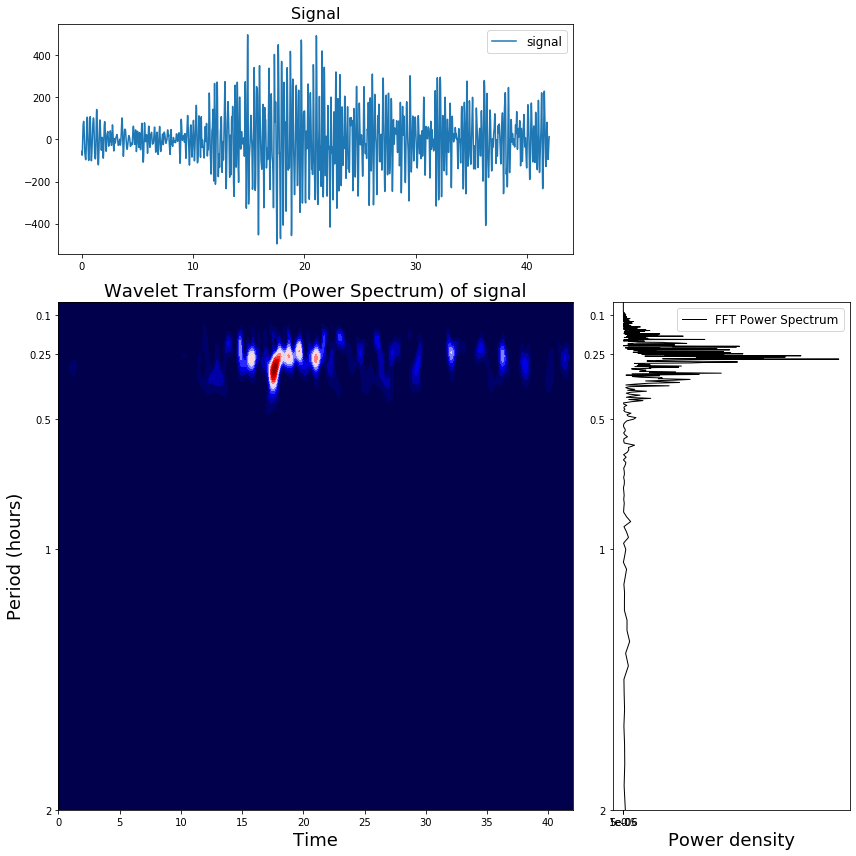

In [40]:
N = df2.shape[0]
t0=0
dt= 1./60
time = np.arange(0, N) * dt + t0
signal = df2['detided'].values.squeeze()
scales = np.arange(1, 120, .1)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (hours)'
xlabel = 'Time'

fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[0:2, 0:4])
bottom_left_ax = fig.add_subplot(spec[2:, 0:4])
bottom_right_ax = fig.add_subplot(spec[2:, 4:])

plot_signal(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
xticks = (0, 0.000005, 0.00001)
plot_fft(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim, xticks = xticks)
#bottom_right_ax.set_ylabel('Period [hours]', fontsize=12)
bottom_right_ax.set_xlabel('Power density', fontsize=18)
plt.tight_layout()
plt.show()

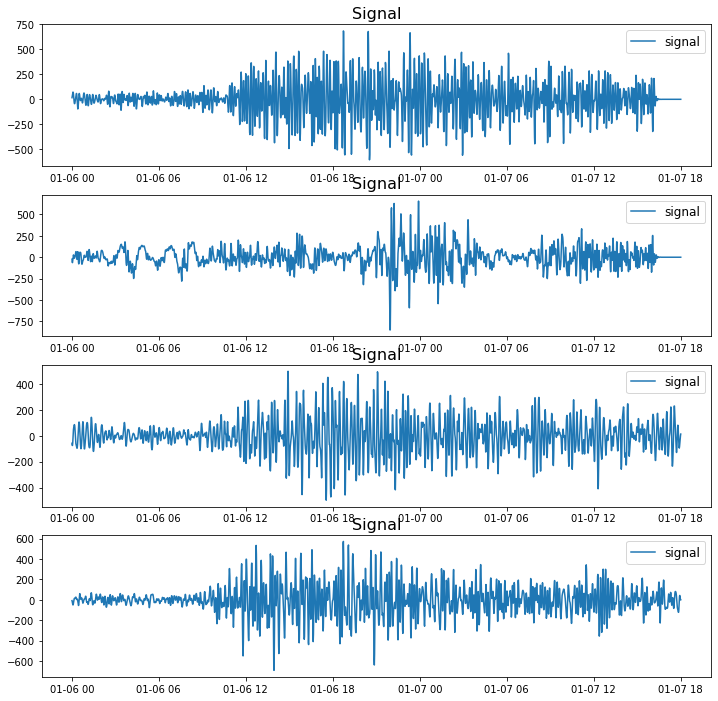

In [41]:
Gauge = ['CAS', 'LAG', 'PEN', 'LEX']
Year = '2014'
fill_type = 'ffill'

t0=0
dt= 1./60
scales = np.arange(1, 120, .1)
ylabel = 'Period (hours)'
xlabel = 'Time'
fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=1, nrows=len(Gauge))

indir = '/home/jihwan/docs/written-ups/notebook/Tutorials/meteo_tsunami/data/2014_jan/tide/'
for i in range(len(Gauge)):
    dataset = indir + Gauge[i] + '/' + Year + '.'+fill_type + '.detide.pkl'
    df = pd.read_pickle(dataset)
    mask = (df['datetime'] > '2014-01-06') & (df['datetime'] <= '2014-01-07 18:00')
    df2= df.loc[mask]
    
    N = df2.shape[0]
    time = np.arange(0, N) * dt + t0
    signal = df2['detided'].values.squeeze()
    
    ax = fig.add_subplot(spec[i, 0])
    plot_signal(ax, df2['datetime'], signal, average_over = 3)
plt.show()

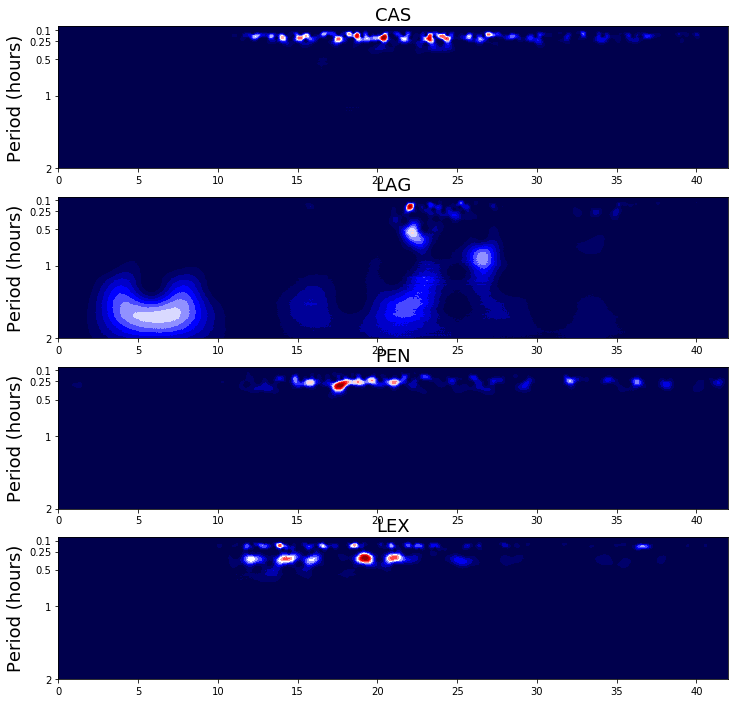

In [35]:
Gauge = ['CAS', 'LAG', 'PEN', 'LEX']
Year = '2014'
fill_type = 'ffill'

t0=0
dt= 1./60
scales = np.arange(1, 120, .1)
ylabel = 'Period (hours)'
xlabel = 'Time'
fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=1, nrows=len(Gauge))

indir = '/home/jihwan/docs/written-ups/notebook/Tutorials/meteo_tsunami/data/2014_jan/tide/'
for i in range(len(Gauge)):
    dataset = indir + Gauge[i] + '/' + Year + '.'+fill_type + '.detide.pkl'
    df = pd.read_pickle(dataset)
    mask = (df['datetime'] > '2014-01-06') & (df['datetime'] <= '2014-01-07 18:00')
    df2= df.loc[mask]
    
    N = df2.shape[0]
    time = np.arange(0, N) * dt + t0
    signal = df2['detided'].values.squeeze()
    
    ax = fig.add_subplot(spec[i, 0])
    plot_wavelet(ax, time, signal, scales, xlabel=' ', ylabel=ylabel, title=Gauge[i])
plt.show()